<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#分析LTEPAT输出结果" data-toc-modified-id="分析LTEPAT输出结果-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>分析LTEPAT输出结果</a></span><ul class="toc-item"><li><span><a href="#导入相关程序库" data-toc-modified-id="导入相关程序库-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>导入相关程序库</a></span></li><li><span><a href="#读取文件" data-toc-modified-id="读取文件-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>读取文件</a></span></li><li><span><a href="#用字典形式存储所有Counter的ID和对应的名字" data-toc-modified-id="用字典形式存储所有Counter的ID和对应的名字-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>用字典形式存储所有Counter的ID和对应的名字</a></span></li><li><span><a href="#分析Excel中指定counter和kpi的数据" data-toc-modified-id="分析Excel中指定counter和kpi的数据-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>分析Excel中指定counter和kpi的数据</a></span><ul class="toc-item"><li><span><a href="#整理合并Sheet中的Counter和KPI数据" data-toc-modified-id="整理合并Sheet中的Counter和KPI数据-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>整理合并Sheet中的Counter和KPI数据</a></span></li><li><span><a href="#抽取counter-dataframe中指定的counter" data-toc-modified-id="抽取counter-dataframe中指定的counter-1.4.2"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>抽取counter dataframe中指定的counter</a></span></li><li><span><a href="#对指定数据进行可视化" data-toc-modified-id="对指定数据进行可视化-1.4.3"><span class="toc-item-num">1.4.3&nbsp;&nbsp;</span>对指定数据进行可视化</a></span></li></ul></li></ul></li></ul></div>

### 分析LTEPAT输出结果

#### 导入相关程序库

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os
import re
% matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#### 读取文件

In [2]:
# 这里的excel文件是LTEPAT处理eNB Snapshot中的PM文件后的输出文件
file_path = r"D:\userdata\anliu\Desktop\log\IRAN\0912\DE5190"
file_name = r"201809142132_PMOutput.xlsx"

os.chdir(file_path)

file = os.path.join(file_path, file_name)
xls = pd.ExcelFile(file)

#### 用字典形式存储所有Counter的ID和对应的名字

In [3]:
def get_counter_name(xls):
    counters = {}
    for sheet in xls.sheet_names:
        if not sheet.startswith('KPI') and not sheet.startswith('Summary') :
            sheet_data = xls.parse(sheet)
            sheet_data.dropna(how='all', axis=1, inplace=True)
            sheet_data.dropna(how='all', axis=0, inplace=True)            
            sheet_cols = sheet_data.columns.tolist()[4:]
            
            for col in sheet_cols:
                cid = col.split(':')[0]
                name = col.split(':')[1]
                counters[cid] = name

    return counters

# counter_all = get_counter_name(xls)

# 将字典内容写入到文件
# outfile = r"D:\userdata\anliu\Desktop\log\IRAN\Snapshot_MRBTS-371324\test.txt"
# with open(outfile, 'w+') as out:
#     for key in counters:
#         out.writelines((key + ',' + counters[key] + '\n'))

#### 分析Excel中指定counter和kpi的数据

##### 整理合并Sheet中的Counter和KPI数据

In [4]:
# LTE counter所在的sheet列表
counter_sheet = [
    'LTE_Inter_eNB_via_S1_Handover', 'LTE_Inter_eNB_via_X2_Handover', 'LTE_VoLTE_Voice_Break_Period_Hi',
    'LTE_M_per_LNCEL', 'LTE_Broadcast', 'LTE_Received_Interference_Power', 'LTE_VoLTE_BLER_Histogram',
    'LTE_RSRP_and_RSRQ_Histogram', 'LTE_UE_Quantity', 'LTE_Mobility_Events', 'LTE_SINR', 'LTE_MBMS', 'LTE_MAC',
    'LTE_HO_RLF_trigger', 'LTE_QoS', 'LTE_UE_and_ServDiff', 'LTE_Handover', 'LTE_Cell_Avail', 'LTE_Inter_Sys_HO',
    'LTE_Inter_eNB_HO', 'LTE_UE_State', 'LTE_Cell_Throughput', 'LTE_Cell_Resource', 'LTE_Pwr_and_Qual_DL',
    'LTE_Intra_eNB_HO', 'LTE_RRC', 'LTE_Radio_Bearer', 'LTE_EPS_Bearer', 'LTE_Pwr_and_Qual_UL', 'LTE_Cell_Load'
]

# LTE KPI所在的sheet列表
kpi_sheet = [
    'KPIs_WBTS_TTIB', 'KPIs_WBTS_CELL OTHER', 'KPIs_WBTS_CELL USAGE', 'KPIs_WBTS_ENB INTEGRITY',
    'KPIs_WBTS_CELL INTEGRITY', 'KPIs_WBTS_CELL USAGE USERS', 'KPIs_WBTS_ENB RETAINABILITY',
    'KPIs_WBTS_ENB USAGE', 'KPIs_WBTS_CELL MOBILITY', 'KPIs_WBTS_CELL RETAINABILITY',
    'KPIs_WBTS_CELL ACCESSIBILITY'
]

# 整理每张sheet的数据，包括读取数据，合并列，去除无效值和不需要的列
def sheet_data_clean_up(sheet):
    sheet_data = xls.parse(sheet)
    # 去除sheet中最后几列的统计数据
    sheet_data = sheet_data[~sheet_data['StartDate'].astype(str).str.startswith('System Level')]
    # 去除所有值都是NA的行和列
    sheet_data.dropna(how='all', axis=1, inplace=True)
    sheet_data.dropna(how='all', axis=0, inplace=True)  
    # 将日期和时间列合并为Time列，删除baseId列，删除localMoid为空的行
    Time = sheet_data.StartDate.astype(str) + ' ' + sheet_data.StartTime.astype(str)
    sheet_data = sheet_data[~sheet_data['localMoid'].isnull()]    
    sheet_data['Time'] = pd.to_datetime(Time)
    sheet_data.drop(axis=1, columns=['StartDate', 'StartTime', 'baseId'], inplace=True)  
    
    return sheet_data

# 合并所有LTE分类sheet的数据
from functools import reduce
def get_category_data(xls, cat_sheet):
    cat_list = []
    for sheet in cat_sheet:
        sheet_data = sheet_data_clean_up(sheet)
        print(sheet, len(sheet_data))
        cat_list.append(sheet_data)
    
    # 合并分类列表并按Time和localMoid排序
    cat_data = reduce(lambda left,right: pd.merge(left,right,on=['Time', 'localMoid'], how='outer'), cat_list)
    cat_data.sort_values(['Time', 'localMoid'], inplace=True)
        
    return cat_data

# 最终数据统计以小区为单位，这里只提取小区对应的数据，去掉其他比如bts级别的数据
def select_data(data):
    p = r'DN\:NE-LNBTS-\d+/LNCEL-\d+/MCC-\d+/MNC-\d+$'
    cells = [i for l in data['localMoid'].unique() for i in re.findall(p, l) if i!=[]]
    data = data[data['localMoid'].isin(cells)]   
    
    return data

In [5]:
counter_data = get_category_data(xls, counter_sheet)
counter_data = select_data(counter_data)

kpi_data = get_category_data(xls, kpi_sheet)
kpi_data = select_data(kpi_data)

LTE_Inter_eNB_via_S1_Handover 144
LTE_Inter_eNB_via_X2_Handover 144
LTE_VoLTE_Voice_Break_Period_Hi 144
LTE_M_per_LNCEL 144
LTE_Broadcast 144
LTE_Received_Interference_Power 144
LTE_VoLTE_BLER_Histogram 144
LTE_RSRP_and_RSRQ_Histogram 144
LTE_UE_Quantity 144
LTE_Mobility_Events 144
LTE_SINR 144
LTE_MBMS 144
LTE_MAC 144
LTE_HO_RLF_trigger 144
LTE_QoS 144
LTE_UE_and_ServDiff 144
LTE_Handover 144
LTE_Cell_Avail 144
LTE_Inter_Sys_HO 144
LTE_Inter_eNB_HO 144
LTE_UE_State 144
LTE_Cell_Throughput 144
LTE_Cell_Resource 144
LTE_Pwr_and_Qual_DL 144
LTE_Intra_eNB_HO 144
LTE_RRC 144
LTE_Radio_Bearer 144
LTE_EPS_Bearer 144
LTE_Pwr_and_Qual_UL 144
LTE_Cell_Load 144
KPIs_WBTS_TTIB 144
KPIs_WBTS_CELL OTHER 144
KPIs_WBTS_CELL USAGE 360
KPIs_WBTS_ENB INTEGRITY 144
KPIs_WBTS_CELL INTEGRITY 192
KPIs_WBTS_CELL USAGE USERS 144
KPIs_WBTS_ENB RETAINABILITY 168
KPIs_WBTS_ENB USAGE 242
KPIs_WBTS_CELL MOBILITY 288
KPIs_WBTS_CELL RETAINABILITY 168
KPIs_WBTS_CELL ACCESSIBILITY 168


##### 抽取counter dataframe中指定的counter

In [6]:
iot = [
       'M8005C317:UL_IOT_PUSCH_DIST_BIN_0 (1.0E-1 dB)', 'M8005C318:UL_IOT_PUSCH_DIST_BIN_1 (1.0E-1 dB)',
       'M8005C319:UL_IOT_PUSCH_DIST_BIN_2 (1.0E-1 dB)', 'M8005C320:UL_IOT_PUSCH_DIST_BIN_3 (1.0E-1 dB)',
       'M8005C321:UL_IOT_PUSCH_DIST_BIN_4 (1.0E-1 dB)', 'M8005C322:UL_IOT_PUSCH_DIST_BIN_5 (1.0E-1 dB)',
       'M8005C323:UL_IOT_PUSCH_DIST_BIN_6 (1.0E-1 dB)', 'M8005C324:UL_IOT_PUSCH_DIST_BIN_7 (1.0E-1 dB)',
       'M8005C325:UL_IOT_PUSCH_DIST_BIN_8 (1.0E-1 dB)', 
#        'M8005C233:RSSI_CELL_PUSCH_MEAN (dBm)', 'M8005C283:SINR_CELL_PUSCH_MEAN (dB)'
      ]

# 仅保留需要处理的columns
def data_crop(data, cols):
    data_crop = pd.concat([data[['Time', 'localMoid']], data[cols]], axis=1)
    # 取消数据中cols列全部为NA值的列
    data_crop.dropna(subset=cols, how='all', inplace=True)
    
    return data_crop

data_iot = data_crop(counter_data, iot)

##### 对指定数据进行可视化

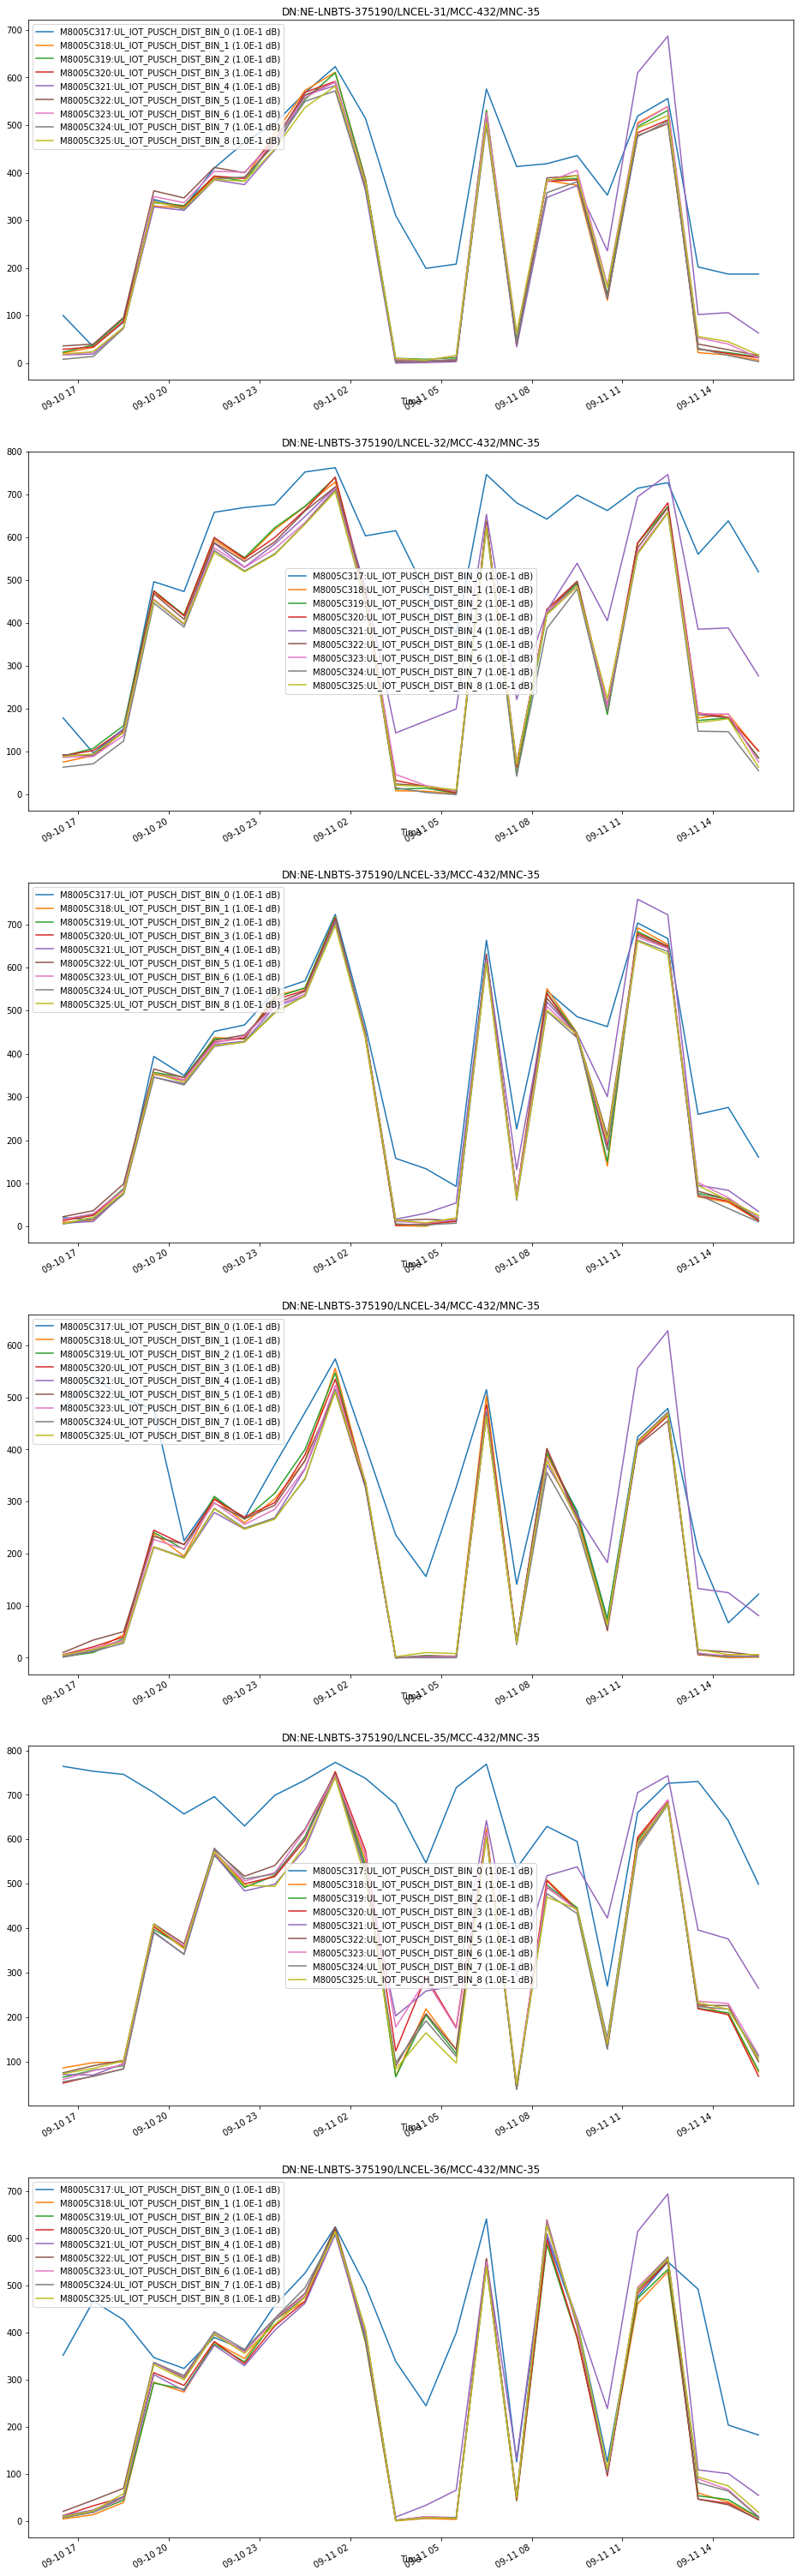

In [12]:
def visual_data(data):
    grouped_by_cell = data.groupby('localMoid')
    # grouped_by_cell.plot(x='Time', y=data_iot.columns[3:12], kind="line", figsize=(16,8))
    fig = plt.figure(figsize=(16,60))
    n = len(grouped_by_cell)
    for i, (name, group) in enumerate(grouped_by_cell):
        ax = fig.add_subplot(n, 1, i+1)
        group.plot(x='Time', y=group.columns[2:], ax=ax, title=name)    
#         days = mdates.DayLocator(interval=1)
#         hours = mdates.HourLocator(interval=6)
#         ax.xaxis.set_major_locator(days)
#         ax.xaxis.set_minor_locator(hours)
#         ax.xaxis.set_major_formatter(mdates.DateFormatter('%D'))
#         ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
#         ax.tick_params(pad=10)
#         ax.legend(loc='lower left', bbox_to_anchor=(0.1, 0.3))
        ax.xaxis.set_label_coords(0.5, -0.05)
    plt.savefig('IoT.jpg')
    
visual_data(data_iot)

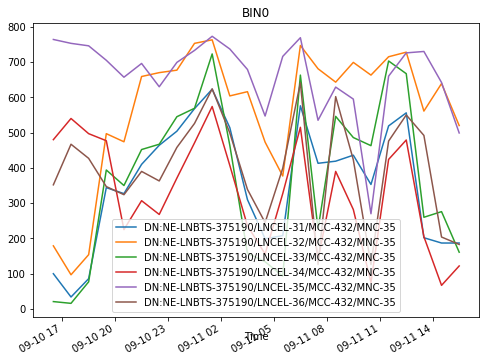

In [13]:
# 比较不同localMoid的同一列数据
grouped_by_cell = data_iot.groupby('localMoid')
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
for i, (name, group) in enumerate(grouped_by_cell):
    group.plot(x='Time', y=group.columns[2], ax=ax, title='BIN0', label=name)
    ax.xaxis.set_label_coords(0.5, -0.05)